In [22]:

import random
import numpy as np
import torch

# Fixer la graine pour les bibliothèques aléatoires
SEED = 42  
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Fixer la graine pour les GPU (si disponible)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Assurer la déterminisme dans les calculs avec PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


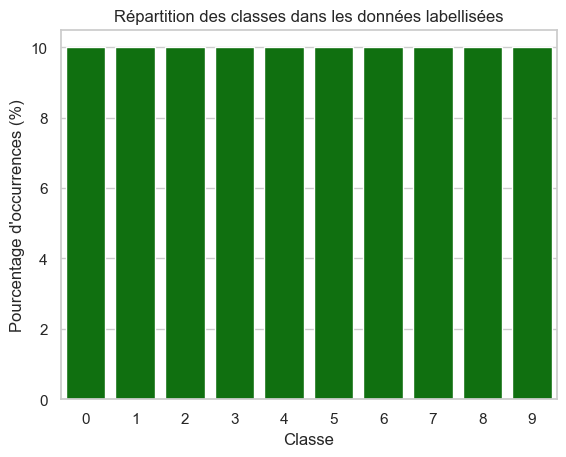

In [23]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Charger le dataset complet
full_trainset = datasets.MNIST(root='./data', train=True, download=True)

# Indices pour chaque classe
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(full_trainset):
    class_indices[label].append(idx)

# Sélectionner 10 indices par classe pour les données labellisées
labeled_indices = []
for cls in range(10):
    labeled_indices.extend(random.sample(class_indices[cls], 10))

# Indices restants pour les données non labellisées
unlabeled_indices = list(set(range(len(full_trainset))) - set(labeled_indices))

# Sous-ensembles
unlabeled_dataset = Subset(full_trainset, unlabeled_indices)  # 59 900 données non labellisées
labeled_dataset = Subset(full_trainset, labeled_indices)      # 100 données labellisées




# Analyse de la répartition des classes dans les données labellisées
class_count_labelled = {}
for i in range(len(labeled_indices)):
    label = full_trainset.targets[labeled_indices[i]].item()  # Récupérer les labels des indices labellisés
    if label not in class_count_labelled:
        class_count_labelled[label] = 0
    class_count_labelled[label] += 1

# Création d'un DataFrame pour faciliter la visualisation
df_labelled = pd.DataFrame(class_count_labelled.items(), columns=["Label", "Occurrence"])
df_labelled["Occurrence (%)"] = (df_labelled["Occurrence"] / len(labeled_indices)) * 100

# Visualisation avec Seaborn
sns.set(style="whitegrid")
sns.barplot(x="Label", y="Occurrence (%)", data=df_labelled, color="green")
plt.title("Répartition des classes dans les données labellisées")
plt.xlabel("Classe")
plt.ylabel("Pourcentage d'occurrences (%)")
plt.show()


# SimCLR with CNN

In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Charger le dataset complet
full_trainset = datasets.MNIST(root='./data', train=True, download=True)

# Indices pour chaque classe
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(full_trainset):
    class_indices[label].append(idx)

# Sélectionner 10 indices par classe pour les données labellisées
labeled_indices = []
for cls in range(10):
    labeled_indices.extend(random.sample(class_indices[cls], 10))

# Indices restants pour les données non labellisées
unlabeled_indices = list(set(range(len(full_trainset))) - set(labeled_indices))

# Sous-ensembles
labeled_dataset = Subset(full_trainset, labeled_indices)      # 100 données labellisées
unlabeled_dataset = Subset(full_trainset, unlabeled_indices)  # 59 900 données non labellisées

# Transformation standard pour les données labellisées
labeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Appliquer les transformations au dataset complet
transformed_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=labeled_transform)

# Transformation pour le pré-entraînement contrastif
contrastive_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset avec transformations contrastives
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignorer les labels pour le pré-entraînement
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

simclr_unlabeled_dataset = SimCLRDataset(unlabeled_dataset, contrastive_transforms)
unlabeled_loader = DataLoader(simclr_unlabeled_dataset, batch_size=256, shuffle=True)

# Backbone CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        return x

# Tête de projection
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Combinaison Backbone + Projection Head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = SimpleCNN()
projection_head = ProjectionHead(input_dim=3136, output_dim=128)
simclr_model = nn.Sequential(cnn, projection_head).to(device)

# Fonction de perte contrastive
def contrastive_loss(projections1, projections2, temperature=0.07):
    z1 = F.normalize(projections1, dim=1)
    z2 = F.normalize(projections2, dim=1)
    similarity_matrix = torch.matmul(z1, z2.T) / temperature
    batch_size = z1.size(0)
    labels = torch.arange(batch_size).to(z1.device)
    loss1 = F.cross_entropy(similarity_matrix, labels)
    loss2 = F.cross_entropy(similarity_matrix.T, labels)
    return (loss1 + loss2) / 2

# Pré-entraînement contrastif
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
epochs = 10
simclr_model.train()
for epoch in range(epochs):
    total_loss = 0
    for (view1, view2) in unlabeled_loader:
        view1, view2 = view1.to(device), view2.to(device)
        projections1 = simclr_model(view1)
        projections2 = simclr_model(view2)
        loss = contrastive_loss(projections1, projections2)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(unlabeled_loader)}")

# Modèle pour le fine-tuning
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)




Epoch 1/10, Loss: 0.7539097320320259
Epoch 2/10, Loss: 0.16623364458990914
Epoch 3/10, Loss: 0.11033484680402993
Epoch 4/10, Loss: 0.08550334209178248
Epoch 5/10, Loss: 0.07247383927560261
Epoch 6/10, Loss: 0.06453956407295842
Epoch 7/10, Loss: 0.056154628658396565
Epoch 8/10, Loss: 0.053308969681971095
Epoch 9/10, Loss: 0.0481061549204537
Epoch 10/10, Loss: 0.046788303961611204



Fine-tuning avec 10 exemples
Taille: 10, Loss: 0.3056

Fine-tuning avec 20 exemples
Taille: 20, Loss: 0.3371

Fine-tuning avec 30 exemples
Taille: 30, Loss: 0.7256

Fine-tuning avec 40 exemples
Taille: 40, Loss: 0.3922

Fine-tuning avec 50 exemples
Taille: 50, Loss: 0.2444

Fine-tuning avec 60 exemples
Taille: 60, Loss: 0.0970

Fine-tuning avec 70 exemples
Taille: 70, Loss: 0.0469

Fine-tuning avec 80 exemples
Taille: 80, Loss: 0.0295

Fine-tuning avec 90 exemples
Taille: 90, Loss: 0.0253

Fine-tuning avec 100 exemples
Taille: 100, Loss: 0.0275


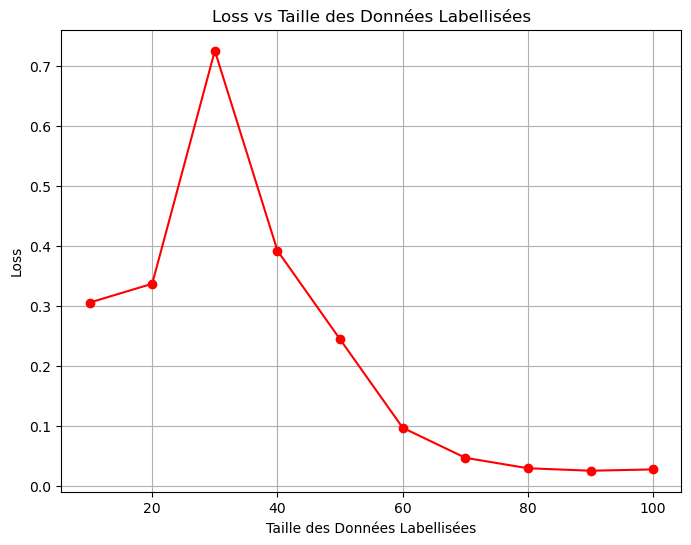

In [3]:
# Charger le backbone pré-entraîné
fine_tune_model_1 = nn.Sequential(cnn, ClassificationHead(input_dim=3136, num_classes=10)).to(device)
optimizer_finetune = optim.Adam(fine_tune_model_1.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement progressif avec lots de tailles croissantes
losses = []
for size in range(10, 101, 10):
    print(f"\nFine-tuning avec {size} exemples")
    subset_indices = labeled_indices[:size]
    subset = Subset(transformed_trainset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=10, shuffle=True)
    fine_tune_model_1.train()
    for epoch in range(5):
        total_loss = 0
        for images, labels in subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = fine_tune_model_1(images)
            loss = criterion(outputs, labels)
            optimizer_finetune.zero_grad()
            loss.backward()
            optimizer_finetune.step()
            total_loss += loss.item()
    avg_loss = total_loss / len(subset_loader)
    losses.append(avg_loss)
    print(f"Taille: {size}, Loss: {avg_loss:.4f}")

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.plot(range(10, 101, 10), losses, marker='o', color='red')
plt.title('Loss vs Taille des Données Labellisées')
plt.xlabel('Taille des Données Labellisées')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### evaluation on test data

Test Loss: 0.3565, Test Accuracy: 0.8886


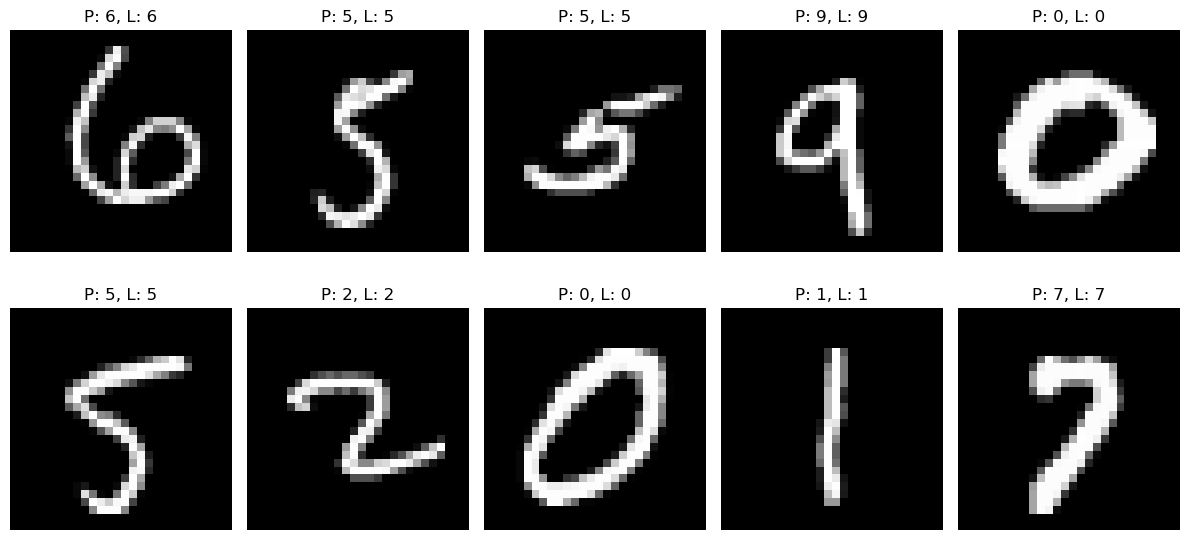

In [4]:
# Charger le dataset de test
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=labeled_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fonction d'évaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

# Évaluer le modèle sur les données de test
test_loss_1, test_accuracy_1, preds_1, labels_1 = evaluate_model(fine_tune_model_1, test_loader, criterion)
print(f"Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_accuracy_1:.4f}")

# Visualisation des prédictions et des labels associés
def plot_predictions(preds_1, labels_1, n_samples=10):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(preds_1)), n_samples)
    for i, idx in enumerate(indices):
        plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(test_dataset[idx][0].squeeze(), cmap='gray')
        plt.title(f"P: {preds_1[idx]}, L: {labels_1[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(preds_1, labels_1)


### with graph

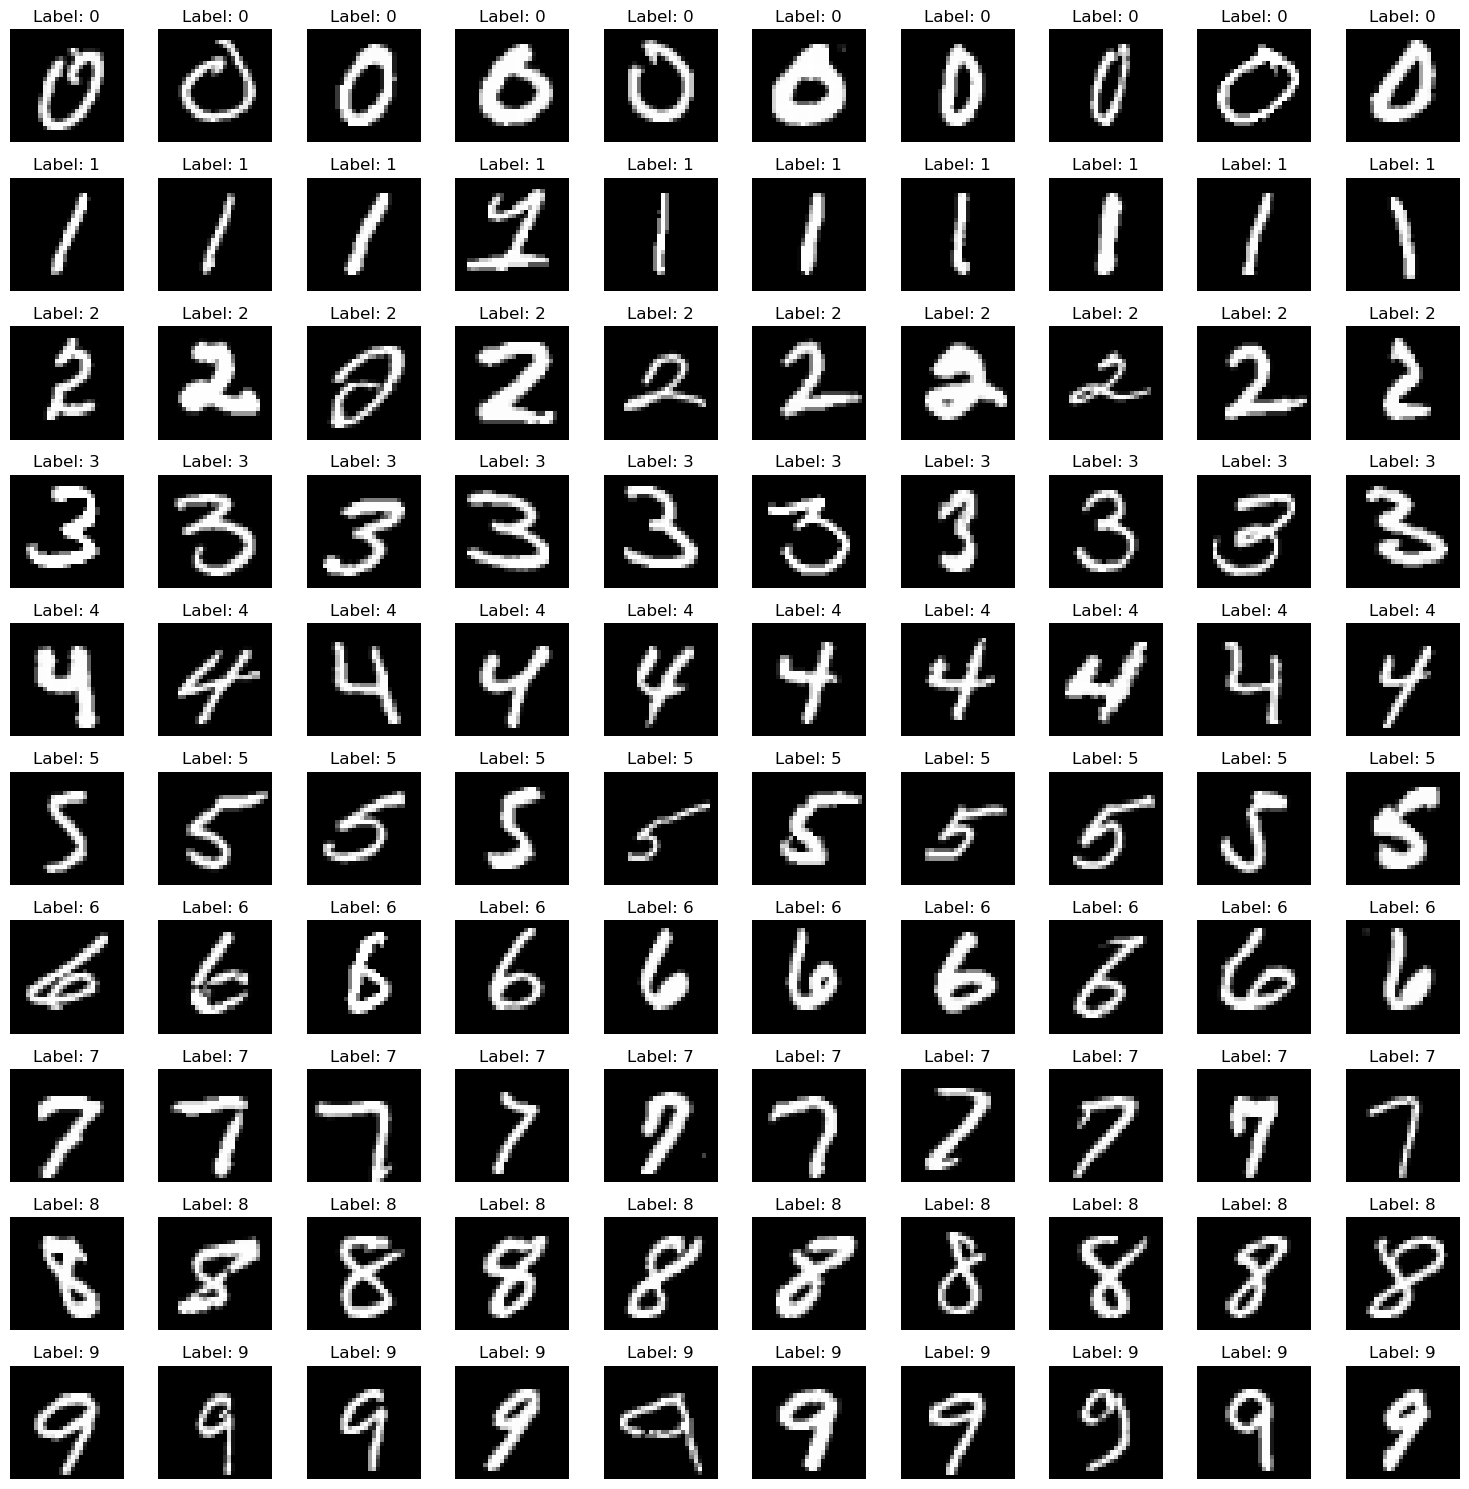

Répartition des labels dans le sous-ensemble étiqueté: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor

# Récupérer les images et les labels du sous-ensemble étiqueté
labeled_images = []
labeled_labels = []

for idx in labeled_indices:
    img, label = full_trainset[idx]
    labeled_images.append(img)
    labeled_labels.append(label)

# Convertir les images en tenseur pour l'affichage
labeled_images_tensor = [ToTensor()(img) for img in labeled_images]

# Visualiser les images
def plot_images(images, labels, ncols=10):
    n = len(images)
    nrows = (n + ncols - 1) // ncols  # Calcul du nombre de lignes
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*1.5))
    axes = axes.flatten()
    
    for i in range(n):
        axes[i].imshow(images[i].squeeze(), cmap="gray")  # Convertir en array et supprimer la dimension supplémentaire
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    
    # Cacher les axes excédentaires
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Affichage des images labellisées
plot_images(labeled_images_tensor, labeled_labels)

# Vérification du nombre d'exemples pour chaque label
label_counts = {i: labeled_labels.count(i) for i in range(10)}
print("Répartition des labels dans le sous-ensemble étiqueté:", label_counts)


## Simcrl with RESNET 

C:\Users\Ninette HOUKPONOU\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ninette HOUKPONOU\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.9929380922490715
Epoch 2/10, Loss: 0.2578493976949627
Epoch 3/10, Loss: 0.170380889541573
Epoch 4/10, Loss: 0.12860931713993734
Epoch 5/10, Loss: 0.10038230120817311
Epoch 6/10, Loss: 0.0854244136179869
Epoch 7/10, Loss: 0.07589833428844428
Epoch 8/10, Loss: 0.07222910852641122
Epoch 9/10, Loss: 0.0654370771227484
Epoch 10/10, Loss: 0.06062570045519079

Fine-tuning avec 10 exemples
Taille: 10, Loss: 0.0456

Fine-tuning avec 20 exemples
Taille: 20, Loss: 0.0021

Fine-tuning avec 30 exemples
Taille: 30, Loss: 0.0212

Fine-tuning avec 40 exemples
Taille: 40, Loss: 0.2203

Fine-tuning avec 50 exemples
Taille: 50, Loss: 0.2461

Fine-tuning avec 60 exemples
Taille: 60, Loss: 0.1495

Fine-tuning avec 70 exemples
Taille: 70, Loss: 0.0521

Fine-tuning avec 80 exemples
Taille: 80, Loss: 0.2130

Fine-tuning avec 90 exemples
Taille: 90, Loss: 0.1259

Fine-tuning avec 100 exemples
Taille: 100, Loss: 0.2312


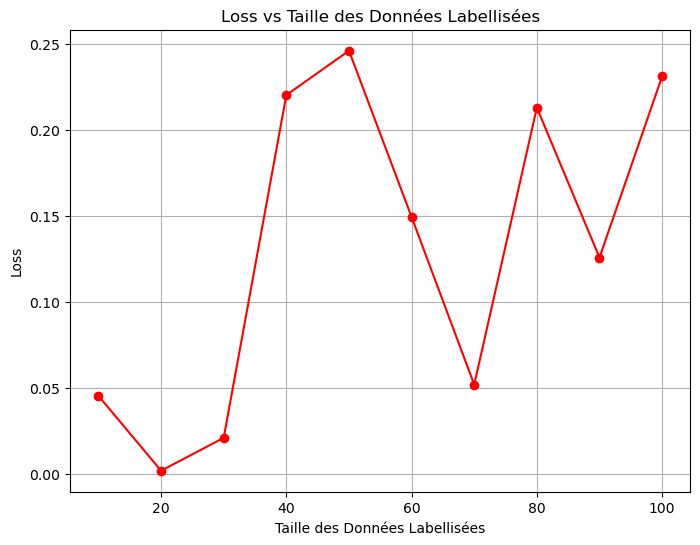

In [16]:
"""
# Charger le dataset complet
full_trainset = datasets.MNIST(root='./data', train=True, download=True)

# Indices pour chaque classe
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(full_trainset):
    class_indices[label].append(idx)

# Sélectionner 10 indices par classe pour les données labellisées
labeled_indices = []
for cls in range(10):
    labeled_indices.extend(random.sample(class_indices[cls], 10))

# Indices restants pour les données non labellisées
unlabeled_indices = list(set(range(len(full_trainset))) - set(labeled_indices))

# Sous-ensembles
labeled_dataset = Subset(full_trainset, labeled_indices)      # 100 données labellisées
unlabeled_dataset = Subset(full_trainset, unlabeled_indices)  # 59 900 données non labellisées

# Transformation standard pour les données labellisées
labeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Appliquer les transformations au dataset complet
transformed_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=labeled_transform)

# Transformation pour le pré-entraînement contrastif
contrastive_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) 

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset


# Dataset avec transformations contrastives
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignorer les labels pour le pré-entraînement
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

simclr_unlabeled_dataset = SimCLRDataset(unlabeled_dataset, contrastive_transforms)
unlabeled_loader = DataLoader(simclr_unlabeled_dataset, batch_size=256, shuffle=True)

# Utiliser ResNet18 comme backbone
class ResNet18Backbone(nn.Module):
    def __init__(self):
        super(ResNet18Backbone, self).__init__()
        resnet = models.resnet18(pretrained=False)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adapter pour MNIST (1 canal)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Retirer la classification finale

    def forward(self, x):
        x = self.backbone(x)
        return x.view(x.size(0), -1)  # Aplatir

# Tête de projection
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Combinaison Backbone + Projection Head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = ResNet18Backbone()
projection_head = ProjectionHead(input_dim=512, output_dim=128)  # ResNet18 sort un vecteur de taille 512
simclr_model = nn.Sequential(backbone, projection_head).to(device)

# Fonction de perte contrastive
def contrastive_loss(projections1, projections2, temperature=0.07):
    z1 = F.normalize(projections1, dim=1)
    z2 = F.normalize(projections2, dim=1)
    similarity_matrix = torch.matmul(z1, z2.T) / temperature
    batch_size = z1.size(0)
    labels = torch.arange(batch_size).to(z1.device)
    loss1 = F.cross_entropy(similarity_matrix, labels)
    loss2 = F.cross_entropy(similarity_matrix.T, labels)
    return (loss1 + loss2) / 2

# Pré-entraînement contrastif
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
epochs = 10
simclr_model.train()
for epoch in range(epochs):
    total_loss = 0
    for (view1, view2) in unlabeled_loader:
        view1, view2 = view1.to(device), view2.to(device)
        projections1 = simclr_model(view1)
        projections2 = simclr_model(view2)
        loss = contrastive_loss(projections1, projections2)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(unlabeled_loader)}")

# Modèle pour le fine-tuning
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Charger le backbone pré-entraîné
fine_tune_model_2 = nn.Sequential(backbone, ClassificationHead(input_dim=512, num_classes=10)).to(device)
optimizer_finetune = optim.Adam(fine_tune_model_2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement progressif avec lots de tailles croissantes
losses = []
for size in range(10, 101, 10):
    print(f"\nFine-tuning avec {size} exemples")
    subset_indices = labeled_indices[:size]
    subset = Subset(transformed_trainset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=10, shuffle=True)
    fine_tune_model_2.train()
    for epoch in range(5):
        total_loss = 0
        for images, labels in subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = fine_tune_model_2(images)
            loss = criterion(outputs, labels)
            optimizer_finetune.zero_grad()
            loss.backward()
            optimizer_finetune.step()
            total_loss += loss.item()
    avg_loss = total_loss / len(subset_loader)
    losses.append(avg_loss)
    print(f"Taille: {size}, Loss: {avg_loss:.4f}")

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.plot(range(10, 101, 10), losses, marker='o', color='red')
plt.title('Loss vs Taille des Données Labellisées')
plt.xlabel('Taille des Données Labellisées')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Test Loss: 0.5777, Test Accuracy: 0.8264


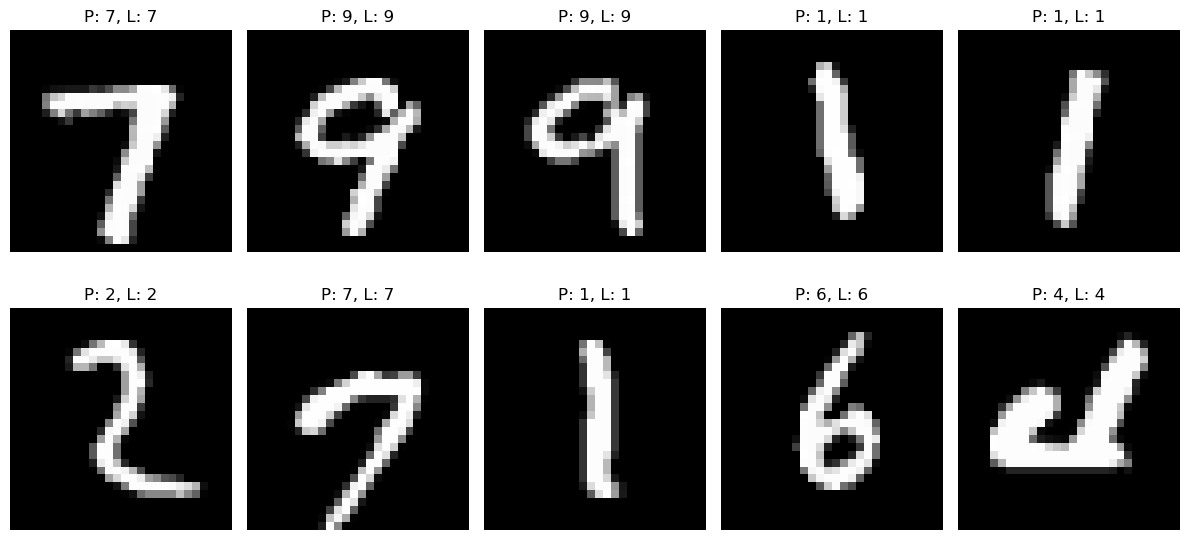

In [18]:
# Charger le dataset de test
"""test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=labeled_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)"""

# Fonction d'évaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

# Évaluer le modèle sur les données de test
test_loss_2, test_accuracy_2, preds_2, labels_2 = evaluate_model(fine_tune_model_2, test_loader, criterion)
print(f"Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_accuracy_2:.4f}")

# Visualisation des prédictions et des labels associés
def plot_predictions(preds_2, labels_2, n_samples=10):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(preds_2)), n_samples)
    for i, idx in enumerate(indices):
        plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(test_dataset[idx][0].squeeze(), cmap='gray')
        plt.title(f"P: {preds_2[idx]}, L: {labels_2[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(preds_2, labels_2)


## Pre-trained

Epoch 1/10, Loss: 1.1256851834109707
Epoch 2/10, Loss: 0.28656689969138205
Epoch 3/10, Loss: 0.18360649638323703
Epoch 4/10, Loss: 0.14150415427791765
Epoch 5/10, Loss: 0.12188165835463084
Epoch 6/10, Loss: 0.10079026185612902
Epoch 7/10, Loss: 0.09236526318913342
Epoch 8/10, Loss: 0.0873870119675357
Epoch 9/10, Loss: 0.07466658220713975
Epoch 10/10, Loss: 0.07314019849221422

Fine-tuning avec 10 exemples
Taille: 10, Loss: 0.0712

Fine-tuning avec 20 exemples
Taille: 20, Loss: 0.0181

Fine-tuning avec 30 exemples
Taille: 30, Loss: 0.2059

Fine-tuning avec 40 exemples
Taille: 40, Loss: 0.3102

Fine-tuning avec 50 exemples
Taille: 50, Loss: 0.5542

Fine-tuning avec 60 exemples
Taille: 60, Loss: 0.3650

Fine-tuning avec 70 exemples
Taille: 70, Loss: 0.6111

Fine-tuning avec 80 exemples
Taille: 80, Loss: 0.4250

Fine-tuning avec 90 exemples
Taille: 90, Loss: 0.4457

Fine-tuning avec 100 exemples
Taille: 100, Loss: 0.3290


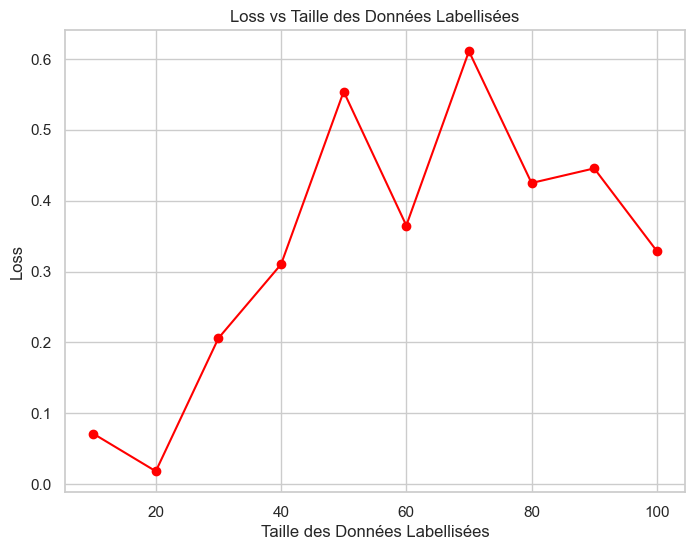

In [39]:
"""
# Charger le dataset complet
full_trainset = datasets.MNIST(root='./data', train=True, download=True)

# Indices pour chaque classe
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(full_trainset):
    class_indices[label].append(idx)

# Sélectionner 10 indices par classe pour les données labellisées
labeled_indices = []
for cls in range(10):
    labeled_indices.extend(random.sample(class_indices[cls], 10))

# Indices restants pour les données non labellisées
unlabeled_indices = list(set(range(len(full_trainset))) - set(labeled_indices))

# Sous-ensembles
labeled_dataset = Subset(full_trainset, labeled_indices)      # 100 données labellisées
unlabeled_dataset = Subset(full_trainset, unlabeled_indices)  # 59 900 données non labellisées

# Transformation standard pour les données labellisées
labeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Appliquer les transformations au dataset complet
transformed_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=labeled_transform)

# Transformation pour le pré-entraînement contrastif
contrastive_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) 

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset


# Dataset avec transformations contrastives
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignorer les labels pour le pré-entraînement
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

simclr_unlabeled_dataset = SimCLRDataset(unlabeled_dataset, contrastive_transforms)
unlabeled_loader = DataLoader(simclr_unlabeled_dataset, batch_size=256, shuffle=True)

# Utiliser ResNet18 comme backbone
class ResNet18Backbone(nn.Module):
    def __init__(self):
        super(ResNet18Backbone, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adapter pour MNIST (1 canal)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Retirer la classification finale

    def forward(self, x):
        x = self.backbone(x)
        return x.view(x.size(0), -1)  # Aplatir

# Tête de projection
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Combinaison Backbone + Projection Head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = ResNet18Backbone()
projection_head = ProjectionHead(input_dim=512, output_dim=128)  # ResNet18 sort un vecteur de taille 512
simclr_model = nn.Sequential(backbone, projection_head).to(device)

# Fonction de perte contrastive
def contrastive_loss(projections1, projections2, temperature=0.07):
    z1 = F.normalize(projections1, dim=1)
    z2 = F.normalize(projections2, dim=1)
    similarity_matrix = torch.matmul(z1, z2.T) / temperature
    batch_size = z1.size(0)
    labels = torch.arange(batch_size).to(z1.device)
    loss1 = F.cross_entropy(similarity_matrix, labels)
    loss2 = F.cross_entropy(similarity_matrix.T, labels)
    return (loss1 + loss2) / 2

# Pré-entraînement contrastif
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
epochs = 10
simclr_model.train()
for epoch in range(epochs):
    total_loss = 0
    for (view1, view2) in unlabeled_loader:
        view1, view2 = view1.to(device), view2.to(device)
        projections1 = simclr_model(view1)
        projections2 = simclr_model(view2)
        loss = contrastive_loss(projections1, projections2)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(unlabeled_loader)}")

# Modèle pour le fine-tuning
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Charger le backbone pré-entraîné
fine_tune_model_2 = nn.Sequential(backbone, ClassificationHead(input_dim=512, num_classes=10)).to(device)
optimizer_finetune = optim.Adam(fine_tune_model_2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement progressif avec lots de tailles croissantes
losses = []
for size in range(10, 101, 10):
    print(f"\nFine-tuning avec {size} exemples")
    subset_indices = labeled_indices[:size]
    subset = Subset(transformed_trainset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=10, shuffle=True)
    fine_tune_model_2.train()
    for epoch in range(5):
        total_loss = 0
        for images, labels in subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = fine_tune_model_2(images)
            loss = criterion(outputs, labels)
            optimizer_finetune.zero_grad()
            loss.backward()
            optimizer_finetune.step()
            total_loss += loss.item()
    avg_loss = total_loss / len(subset_loader)
    losses.append(avg_loss)
    print(f"Taille: {size}, Loss: {avg_loss:.4f}")

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.plot(range(10, 101, 10), losses, marker='o', color='red')
plt.title('Loss vs Taille des Données Labellisées')
plt.xlabel('Taille des Données Labellisées')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Test Loss: 0.7414, Test Accuracy: 0.7769


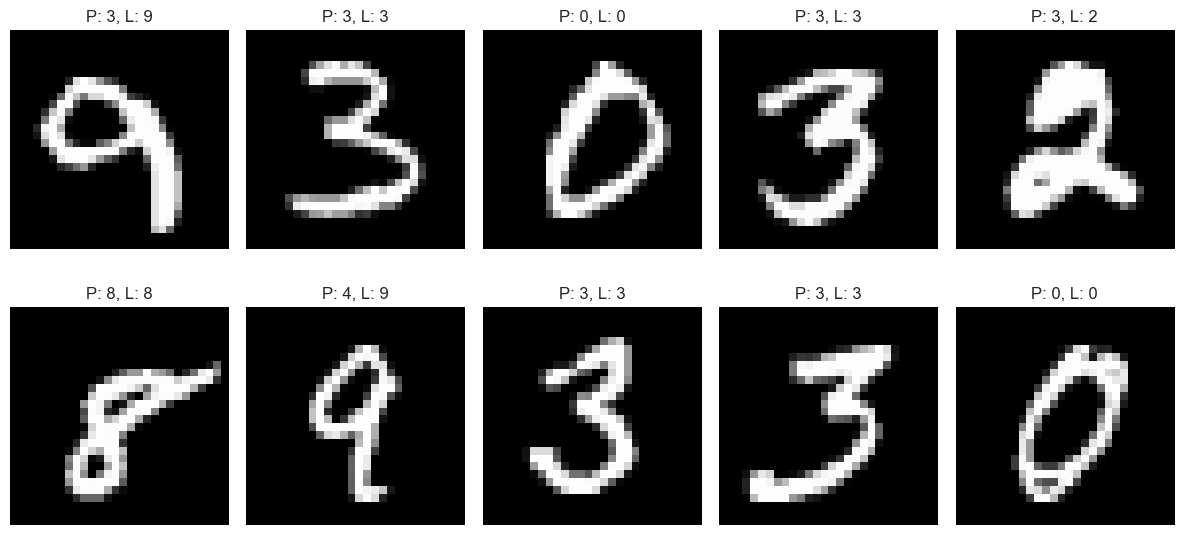

In [41]:
# Charger le dataset de test
"""test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=labeled_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)"""

# Fonction d'évaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

# Évaluer le modèle sur les données de test
test_loss_3, test_accuracy_3, preds_3, labels_3 = evaluate_model(fine_tune_model_2, test_loader, criterion)
print(f"Test Loss: {test_loss_3:.4f}, Test Accuracy: {test_accuracy_3:.4f}")

# Visualisation des prédictions et des labels associés
def plot_predictions(preds_3, labels_3, n_samples=10):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(preds_3)), n_samples)
    for i, idx in enumerate(indices):
        plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(test_dataset[idx][0].squeeze(), cmap='gray')
        plt.title(f"P: {preds_3[idx]}, L: {labels_3[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(preds_3, labels_3)


In [ ]:
# Test with LARS

Epoch 1/10, Loss: 0.1517739707811011
Epoch 2/10, Loss: 0.04847877118418105
Epoch 3/10, Loss: 0.041288277365139917
Epoch 4/10, Loss: 0.037976356708786935
Epoch 5/10, Loss: 0.0359204109503418
Epoch 6/10, Loss: 0.033913569230363406
Epoch 7/10, Loss: 0.034623047687176965
Epoch 8/10, Loss: 0.032660344281257726
Epoch 9/10, Loss: 0.03210194280737231
Epoch 10/10, Loss: 0.03182469697621388

Fine-tuning avec 10 exemples
Taille: 10, Loss: 0.1844

Fine-tuning avec 20 exemples
Taille: 20, Loss: 0.2795

Fine-tuning avec 30 exemples
Taille: 30, Loss: 0.5388

Fine-tuning avec 40 exemples
Taille: 40, Loss: 0.3972

Fine-tuning avec 50 exemples
Taille: 50, Loss: 0.1550

Fine-tuning avec 60 exemples
Taille: 60, Loss: 0.1273

Fine-tuning avec 70 exemples
Taille: 70, Loss: 0.0442

Fine-tuning avec 80 exemples
Taille: 80, Loss: 0.0203

Fine-tuning avec 90 exemples
Taille: 90, Loss: 0.0178

Fine-tuning avec 100 exemples
Taille: 100, Loss: 0.0234


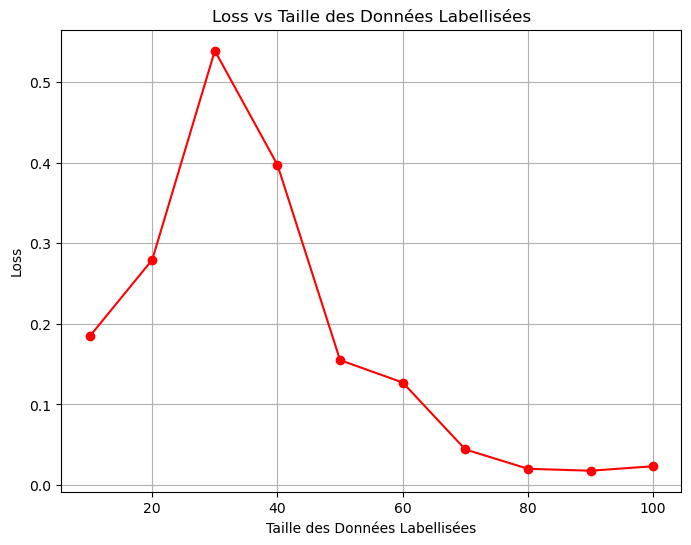

In [5]:


# LARS Optimizer - Implémentation personnalisée
class LARS(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, weight_decay=0.0, trust_coef=0.001):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coef=trust_coef)
        super(LARS, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if group['weight_decay'] != 0:
                    d_p.add_(p.data, alpha=group['weight_decay'])

                # LARS scaling
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(d_p)
                if param_norm > 0 and grad_norm > 0:
                    trust_ratio = group['trust_coef'] * param_norm / (grad_norm + 1e-6)
                    d_p.mul_(trust_ratio)

                # Momentum update
                if 'momentum_buffer' not in self.state[p]:
                    buf = self.state[p]['momentum_buffer'] = torch.clone(d_p).detach()
                else:
                    buf = self.state[p]['momentum_buffer']
                    buf.mul_(group['momentum']).add_(d_p)
                p.data.add_(buf, alpha=-group['lr'])

        return loss







optimizer = LARS(simclr_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
epochs = 10
simclr_model.train()
for epoch in range(epochs):
    total_loss = 0
    for (view1, view2) in unlabeled_loader:
        view1, view2 = view1.to(device), view2.to(device)
        projections1 = simclr_model(view1)
        projections2 = simclr_model(view2)
        loss = contrastive_loss(projections1, projections2)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(unlabeled_loader)}")

# Modèle pour le fine-tuning
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Charger le backbone pré-entraîné
fine_tune_model_1 = nn.Sequential(cnn, ClassificationHead(input_dim=3136, num_classes=10)).to(device)
optimizer_finetune = optim.Adam(fine_tune_model_1.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement progressif avec lots de tailles croissantes
losses = []
for size in range(10, 101, 10):
    print(f"\nFine-tuning avec {size} exemples")
    subset_indices = labeled_indices[:size]
    subset = Subset(transformed_trainset, subset_indices)
    subset_loader = DataLoader(subset, batch_size=10, shuffle=True)
    fine_tune_model_1.train()
    for epoch in range(5):
        total_loss = 0
        for images, labels in subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = fine_tune_model_1(images)
            loss = criterion(outputs, labels)
            optimizer_finetune.zero_grad()
            loss.backward()
            optimizer_finetune.step()
            total_loss += loss.item()
    avg_loss = total_loss / len(subset_loader)
    losses.append(avg_loss)
    print(f"Taille: {size}, Loss: {avg_loss:.4f}")

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.plot(range(10, 101, 10), losses, marker='o', color='red')
plt.title('Loss vs Taille des Données Labellisées')
plt.xlabel('Taille des Données Labellisées')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Test Loss: 0.3467, Test Accuracy: 0.8940


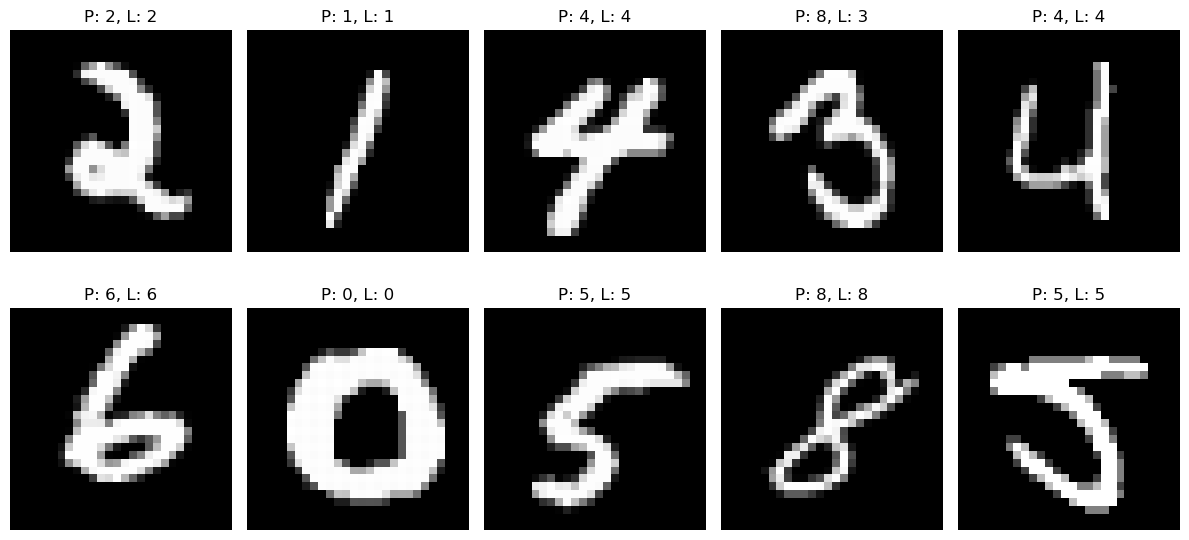

In [7]:
# Charger le dataset de test
#test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=labeled_transform)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



# Évaluer le modèle sur les données de test
test_loss_1, test_accuracy_1, preds_1, labels_1 = evaluate_model(fine_tune_model_1, test_loader, criterion)
print(f"Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_accuracy_1:.4f}")

# Visualisation des prédictions et des labels associés
def plot_predictions(preds_1, labels_1, n_samples=10):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(preds_1)), n_samples)
    for i, idx in enumerate(indices):
        plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(test_dataset[idx][0].squeeze(), cmap='gray')
        plt.title(f"P: {preds_1[idx]}, L: {labels_1[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(preds_1, labels_1)
